## 通过已有的员工信息和离职表现来搭建相应的员工离职预测模型，可以预测之后的员工是否会离职。

### 1、数据读取与预处理

In [4]:
import pandas as pd
df = pd.read_excel('datasets/员工离职预测模型.xlsx')
df.head()

,工资,满意度,考核得分,工程数量,月工时,工龄,离职
0,低,3.8,0.53,2,157,3,1
1,中,8.0,0.86,5,262,6,1
2,中,1.1,0.88,7,272,4,1
3,低,7.2,0.87,5,223,5,1
4,低,3.7,0.52,2,159,3,1


#### 对工资进行数值化处理

In [5]:
df = df.replace({'工资': {'低':0, '中': 1, '高': 2}})
df.head()

,工资,满意度,考核得分,工程数量,月工时,工龄,离职
0,0,3.8,0.53,2,157,3,1
1,1,8.0,0.86,5,262,6,1
2,1,1.1,0.88,7,272,4,1
3,0,7.2,0.87,5,223,5,1
4,0,3.7,0.52,2,159,3,1


### 2、提取特征变量和目标变量

In [6]:
x = df.drop(columns='离职')
y = df['离职']

### 3、划分测试集和训练集

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123) # 划分训练集和测试集，其中X_train、y_train为训练集数据，X_test、y_test为测试集数据

In [8]:
x_train

,工资,满意度,考核得分,工程数量,月工时,工龄
3553,0,7.3,0.93,5,162,4
2112,0,4.3,0.52,2,160,3
1794,0,3.8,0.51,2,159,3
13886,0,6.3,0.71,4,244,2
11251,1,8.8,0.71,5,219,2
...,...,...,...,...,...,...
5218,1,6.3,0.80,4,256,4
12252,0,9.2,0.76,5,132,3
1346,0,7.3,0.95,4,223,6
11646,1,8.5,0.76,3,197,5


In [9]:
y_train

3553     1
2112     1
1794     1
13886    0
11251    0
        ..
5218     0
12252    0
1346     1
11646    0
3582     0
Name: 离职, Length: 12000, dtype: int64

### 4、模型训练及搭建

In [10]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=3, random_state=123) # 设置树的最大深度参数max_depth为3，并设置随机状态参数random_state为数字123，使每次程序运行的结果保持一致。
model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=123)

### 5、模型预测及评估

#### （1）直接预测是否离职

In [11]:
y_pred = model.predict(x_test)
print(y_pred[0:100])

[0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0]


将模型的预测值y_pred和测试集的实际值y_test进行汇总。其中y_pred是一个numpy.ndarray类型的一维数组结构，y_test为Series类型的一维序列结构，用list()函数将它们都转换为列表，再将它们集成到一个DataFrame中

In [12]:
a = pd.DataFrame()
a['预测值'] = list(y_pred)
a['实际值'] = list(y_test)
a.head()

,预测值,实际值
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0


In [13]:
# 查看整体的预测准确度
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
score

0.9573333333333334

#### （2）预测不离职和离职的概率

In [14]:
# 获得的y_pred_proba是一个二维数组，数组左列为分类为0的概率，右列为分类为1的概率；可以将其转换为DataFrame格式以方便查看
y_pred_proba = model.predict_proba(x_test)
b = pd.DataFrame(y_pred_proba, columns=['不离职概率', '离职概率'])
b.head()

,不离职概率,离职概率
0,0.985261,0.014739
1,0.985261,0.014739
2,0.286006,0.713994
3,0.985261,0.014739
4,0.922832,0.077168


In [15]:
# 提取离职概率
y_pred_proba[:, 1]

array([0.01473923, 0.01473923, 0.71399387, ..., 0.01473923, 0.94594595,
       0.01473923])

#### （3）模型预测效果评估
对于分类模型，我们不仅关心预测准确度，更关心命中率（所有实际离职的员工中被预测为离职的员工所占的比率）和假警报率（所有实际不离职的员工中被预测为离职的员工所占的比率）这两个指标，并通过这两个指标绘制ROC曲线来评估模型。

我们希望在阈值相同的情况下，假警报率尽可能小，命中率尽可能高，即ROC曲线尽可能陡峭，其对应的AUC值（ROC曲线下方的面积）尽可能高。

下述代码可以求出在不同阈值下的命中率（TPR）和假警报率（FPR），从而绘制出ROC曲线。

In [16]:
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(y_test, y_pred_proba[:, 1])  # roc 函数

a = pd.DataFrame()
a['阈值'] = list(thres)
a['假报警率'] = list(fpr)
a['命中率'] = list(tpr)

a.head(7)

,阈值,假报警率,命中率
0,2.000000,0.000000,0.000000
1,1.000000,0.000000,0.247110
2,0.945946,0.008232,0.677746
3,0.713994,0.038128,0.942197
4,0.077168,0.159879,0.969653
5,0.059406,0.171577,0.972543
6,0.045763,0.240035,0.976879


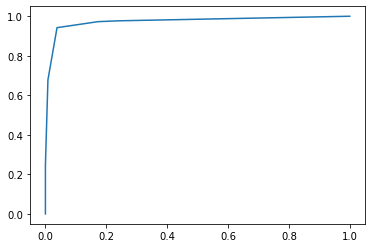

In [14]:
# 绘制ROC曲线
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.show()

In [17]:
# 求出模型的AUC值
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_test, y_pred_proba[:, 1])
print(score)

0.9736722483245008


#### （4）特征重要性评估
模型搭建完成后，有时还需要知道各个特征变量的重要程度，即哪些特征变量在模型中发挥的作用更大，这个重要程度称为特征重要性。在决策树模型中，一个特征变量对模型整体的基尼系数下降的贡献越大，它的特征重要性就越大。

In [18]:
# 特征重要性评估
model.feature_importances_

features = x.columns #获取特征名称
importance = model.feature_importances_ #获取特征重要性
#以二维表格形式显示
importance_df = pd.DataFrame()
importance_df['特征名称'] = features
importance_df['特征重要性'] = importance
importance_df.sort_values('特征重要性' , ascending=False)

,特征名称,特征重要性
1,满意度,0.598109
5,工龄,0.150866
2,考核得分,0.140074
3,工程数量,0.106387
4,月工时,0.004565
0,工资,0.000000


In [19]:
model.feature_importances_

array([0.        , 0.59810862, 0.14007392, 0.10638659, 0.00456495,
       0.15086592])

## 决策树模型可视化呈现
使用Python的Graphviz插件将决策树模型以可视化的方式展示出来。模型的可视化呈现主要是为了演示，在实战中应用较少，可以通过分析可视化的结果，帮助理解决策树的重要知识点。

### 1．节点各元素的含义
除了叶子节点外，每个节点都有5个元素：分裂依据、gini（当前基尼系数）、samples（当前样本数）、value（样本中各类别的数量）、class（分类类别）。

以根节点为例，其分裂依据为满意度是否小于等于4.65；当前基尼系数gini为0.365；当前样本数samples为12000；value后中括号中左边的数值9120表示“离职”列中的0的数量，即不离职员工的数量，右边的数值2880表示“离职”列中的1的数量，即离职员工的数量；分类类别class为“不离职”，这是因为这个节点中不离职员工的数量9120多于离职员工的数量2880，不过根节点的class没有什么意义，模型的预测结果取决于最后叶子节点的class。

### 2．节点划分依据的合理性验证
根节点分裂出两个子节点。左边的子节点中大部分为离职员工（共3367人，其中1325人未离职、2042人离职，该节点的基尼系数为0.477）；而右边的节点中大部分为不离职员工（共8633人，其中7795人未离职、838人离职，该节点的基尼系数为0.175）。这一点的确符合现实中如果满意度较低则离职可能性较大的经验。

In [20]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(model, out_file=None, class_names=['0','1'])
graph = graphviz.Source(dot_data)
graph.render("release/DecisionTreeresult")

'release/DecisionTreeresult.pdf'

## 参数调优：K折交叉验证与GridSearch网格搜索
机器学习的各个模型其实都有一些内置的参数，如决策树模型就用到了一个很重要的参数max_depth（树的最大深度），这种参数又称为超参数。除了max_depth，决策树模型还有一些常用参数，如criterion（特征选择标准）、min_samples_leaf（叶子节点的最少样本数）等。

大多数情况下，使用模型的默认参数也能获得较好的结果及预测准确度，然而如果想要获得更精确的结果，就需要对模型的超参数进行调优。例如，max_depth取3还是取默认值None（即不限制最大深度，分裂到所有叶子节点的基尼系数都为0）是有讲究的，如果取值过小，可能会导致模型欠拟合，如果取值过大，则容易导致模型过拟合，因此需要一个手段来合理地调节模型参数。

调节模型参数的常用方法GridSearch网格搜索，以及常与其搭配使用的K折交叉验证。

###  K折交叉验证
在机器学习中，因为训练集和测试集的数据划分是随机的，所以有时会重复地使用数据，以便更好地评估模型的有效性，并选出最好的模型，该做法称为交叉验证。具体而言就是对原始样本数据进行切分，然后组合成为多组不同的训练集和测试集，用训练集训练模型，用测试集评估模型。某次的训练集可能是下次的测试集，故而称为交叉验证。交叉验证的方法有简单交叉验证、K折交叉验证和留一交叉验证3种。其中K折交叉验证应用较为广泛，它是指将数据集随机等分为K份，每次选取K-1份作为训练集，用剩下的1份作为测试集，得到K个模型后将这K个模型的平均测试效果作为最终的模型效果。

通常来说，如果训练集相对较小，则增大K值，这样在每次迭代过程中将会有更多数据用于模型训练，同时算法时间延长；如果训练集相对较大，则减小K值，这样可以降低模型在不同的数据块上进行重复拟合性能评估的计算成本，在平均性能的基础上获得模型的准确评估。

In [21]:
from sklearn.model_selection import cross_val_score  # 引入交叉验证的函数cross_val_score()
acc = cross_val_score(model, x, y, cv=5)  # 用cross_val_score()函数进行交叉验证，传入的参数依次为模型名称（model）、特征变量数据（X）、目标变量数据（y）、交叉验证的次数（cv）。这里设置cv为5，表示交叉验证5次，每次随机取4/5的数据用于训练，1/5的数据用于测试。如果不设置该参数，则默认交叉验证3次。
print(acc)
print(acc.mean())

[0.96666667 0.96066667 0.959      0.96233333 0.91366667]
0.9524666666666667


In [22]:
# 上面默认以准确度作为评估标准，如果想以ROC曲线的AUC值作为评估标准，则可以设置scoring参数为'roc_auc'，
acc = cross_val_score(model, x, y, scoring='roc_auc', cv=5)
print(acc)
print(acc.mean())

[0.97146884 0.9674637  0.96641351 0.97047305 0.95030156]
0.9652241309284616


### GridSearch网格搜索
是一种穷举搜索的参数调优手段：遍历所有的候选参数，循环建立模型并评估模型的有效性和准确性，选取表现最好的参数作为最终结果。

以决策树模型最大深度参数max_depth为例，我们可以在[1，3，5，7，9]这些值中遍历，以准确度或ROC曲线的AUC值作为评估标准来搜索最合适的max_depth值。如果要同时调节多个模型参数，例如，模型有2个参数，第1个参数有4种可能，第2个参数有5种可能，所有的可能性可以表示成4×5的网格，那么遍历的过程就像是在网格（Grid）里搜索（Search），这就是该方法名称的由来。

In [23]:
# 单参数调优
from sklearn.model_selection import GridSearchCV # 从Scikit-Learn库中引入GridSearchCV()函数
parameters = {'max_depth': [1, 3, 5, 7, 9]}      # 指定决策树模型中待调优参数max_depth的候选值范围
model = DecisionTreeClassifier()  # 构建决策树模型并将其赋给变量model
grid_search = GridSearchCV(model, parameters, scoring='roc_auc', cv=5)  # 表示以ROC曲线的AUC值作为评估标准，如果不设置则以默认值'accuracy'（准确度）作为评估标准，设置cv参数为5，表示进行5折交叉验证

grid_search.fit(x_train, y_train)  # 传入测试集数据开始进行参数调优
grid_search.best_params_

{'max_depth': 7}

因为为max_depth参数设置了5个候选值，又设置了5折交叉验证，所以对于每个候选值，模型都会运行5遍（共运行5×5＝25遍），每个候选值都通过5折交叉验证获得一个平均分，根据平均分进行排序，得到参数的最优值如下所示，即决策树的最大深度设置为7时最优